In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import numpy as np
import os
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Classes
0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

In [4]:
class_dict = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

Recursive function to traverse through a given directory and all its subdirectories to obtain all Wave audio files.

In [5]:
def get_audio_files(path:str):
    counter = 0
    files = []
    
    for file in os.listdir(path):
        if os.path.isdir(f"{path}/{file}"):
            files.extend(get_audio_files(f"{path}/{file}"))
        else:
            title, ext = os.path.splitext(f"{path}/{file}")
            if ext == '.wav':
                files.append(title + ext)
                counter += 1
    print(path)
    print(f'Audio files in folder: {counter}')
    print("")
    return files
    
        

audio_paths = get_audio_files('data')

data/fold2
Audio files in folder: 888

data/fold5
Audio files in folder: 936

data/fold4
Audio files in folder: 990

data/fold3
Audio files in folder: 925

data/fold8
Audio files in folder: 806

data/fold6
Audio files in folder: 823

data/fold1
Audio files in folder: 873

data/fold7
Audio files in folder: 838

data/fold9
Audio files in folder: 816

data/fold10
Audio files in folder: 837

data
Audio files in folder: 0



### Dictionary of audio samples and sample rates

In [6]:
files_loaded = {file: librosa.load(file) for file in audio_paths}

### Audio length (seconds) 

In [12]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    sample_duration = 1 / sample_rate
    audio_length = len(samples) * sample_duration
    df.loc[df['slice_file_name'] == file, 'duration'] = audio_length
    

In [13]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,duration
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,NaN
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,NaN
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,NaN
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,NaN
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,NaN
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,NaN
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,NaN
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,NaN
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,NaN


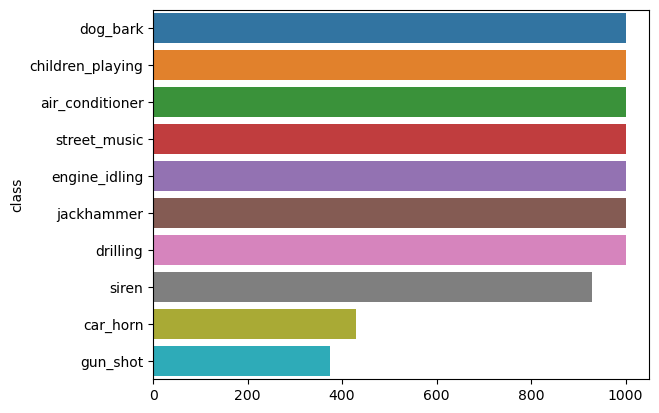

In [14]:
classes = df['class'].value_counts()
sns.barplot(y = classes.index, x = classes.values);

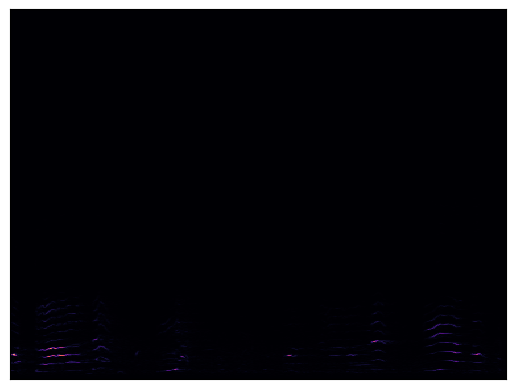

In [144]:
sgram = librosa.stft(samples)

librosa.display.specshow(sgram);

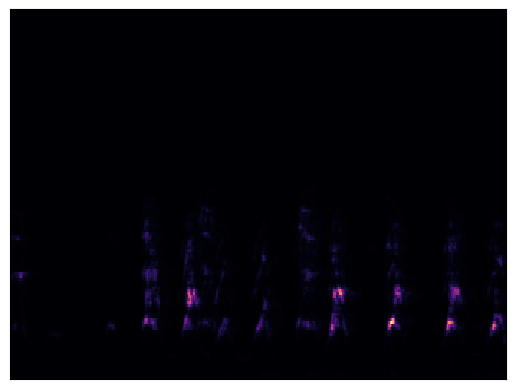

In [333]:
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram);

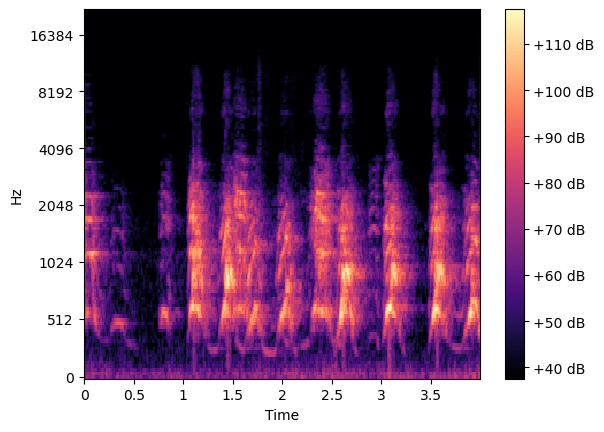

In [334]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

### RMS Energy 

RMS energy is a way to measure the average power of a signal over time. It gives a single value that represents the overall "strength" of a signal, even if it fluctuates.

It's calculated by taking the square root of the mean of the squared values of the signal. This emphasizes the contribution of larger fluctuations compared to smaller ones.

Larger RMS values indicate higher average power or intensity.

It's not the same as the peak value of the signal, which captures the highest individual point.

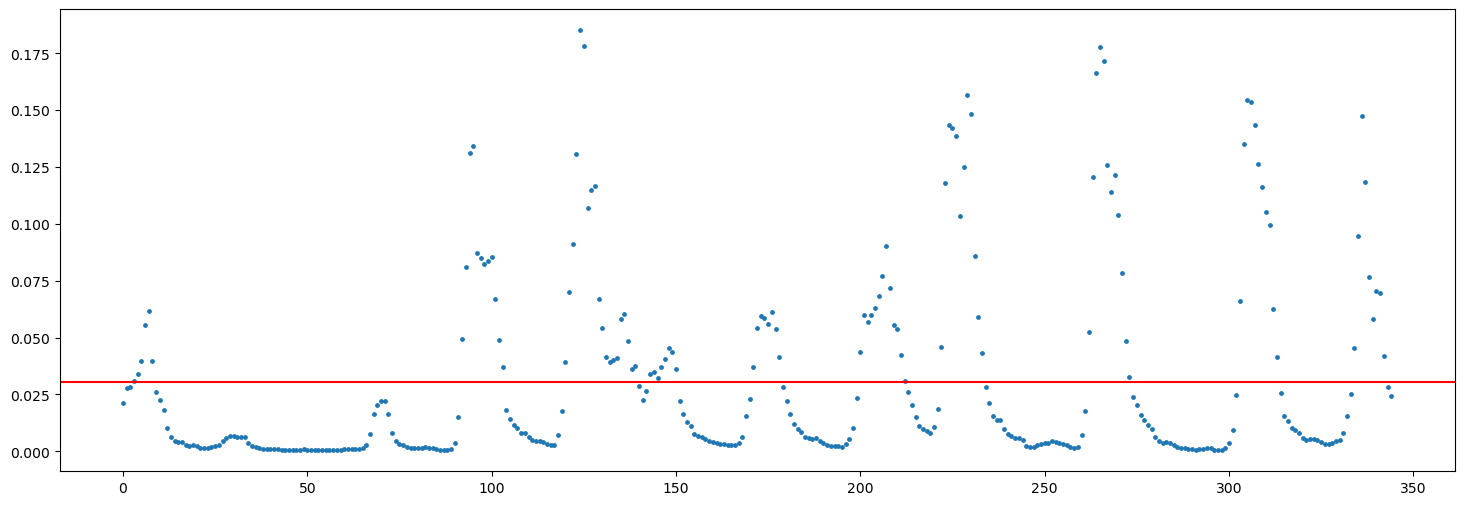

In [368]:
fig, ax = plt.subplots(figsize = (18, 6))
x = np.arange(345)
ax.scatter(x = x, y = rms, s = 6)
ax.axhline(y = rms.mean(), c = 'red');

Extracting means and assigning rms values to each file

In [15]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    sgram = librosa.stft(samples)
    rms = librosa.feature.rms(S = sgram)
    rms_mean = rms.mean()
    rms_std = rms.std()
    file_name = file.split('/')[-1]
    df.loc[df['slice_file_name'] == file_name, 'rms_mean'] = rms_mean
    df.loc[df['slice_file_name'] == file_name, 'rms_std'] = rms_std
  

In [16]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,duration,rms_mean,rms_std
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,NaN,0.070916,0.069788
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,NaN,0.002436,0.000695
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,NaN,0.001835,0.000390
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,NaN,0.002816,0.001175
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,NaN,0.001968,0.000328
...,...,...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,NaN,0.002870,0.000611
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,NaN,0.008923,0.006104
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,NaN,0.007745,0.004761
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,NaN,0.005290,0.002110


In [18]:
classes

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

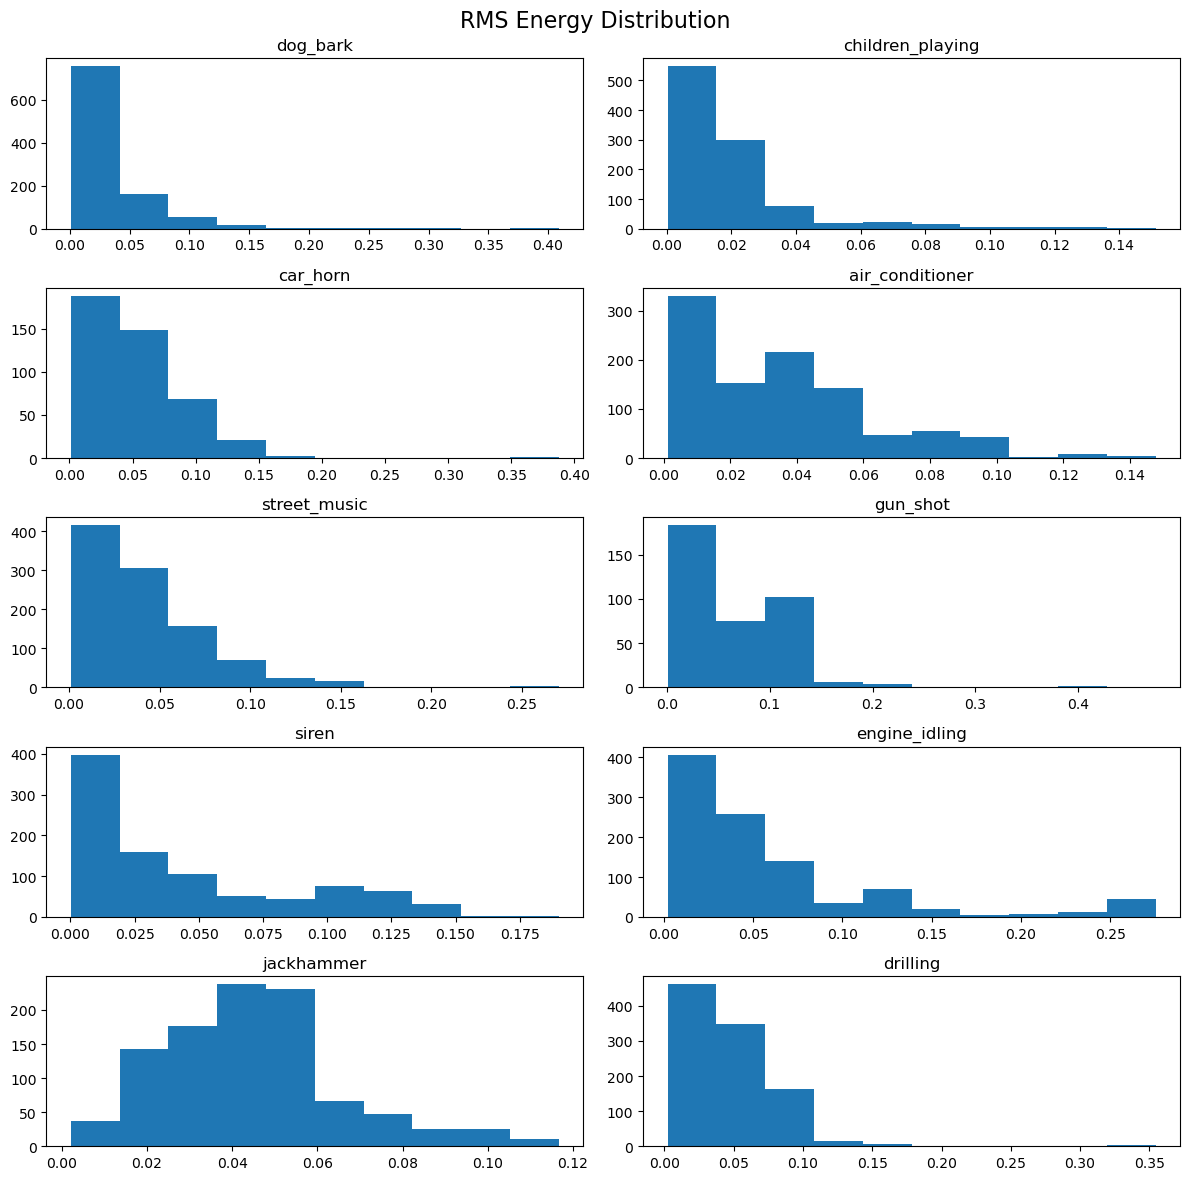

In [20]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 12))
for i, target in enumerate(df['class'].unique()):
    row = i // 2
    col = i % 2
    axes[row, col].hist(df.loc[df['class'] == target, 'rms_mean'])
    axes[row, col].set_title(target)
fig.suptitle('RMS Energy Distribution', fontsize = 16)
plt.tight_layout()


### Zero-Crossing Rate

In [22]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    zcr = librosa.feature.zero_crossing_rate(samples)
    zcr_mean = zcr.mean()
    zcr_std = zcr.std()
    file_name = file.split('/')[-1]
    df.loc[df['slice_file_name'] == file_name, 'zcr_mean'] = zcr_mean
    df.loc[df['slice_file_name'] == file_name, 'zcr_std'] = zcr_std

### Spectral Centroid 

In [24]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    sgram = librosa.stft(samples)
    sgram_mag, _ = librosa.magphase(sgram)
    spec_cent = librosa.feature.spectral_centroid(S=sgram_mag)
    spec_cent_mean = spec_cent.mean()
    spec_cent_std = spec_cent.std()
    file_name = file.split('/')[-1]
    df.loc[df['slice_file_name'] == file_name, 'spec_cent_mean'] = spec_cent_mean
    df.loc[df['slice_file_name'] == file_name, 'spec_cent_std'] = spec_cent_std

In [25]:
df.groupby('class').mean(numeric_only = True)

,fsID,start,end,salience,fold,classID,duration,rms_mean,rms_std,zcr_mean,zcr_std,spec_cent_mean,spec_cent_std
class,,,,,,,,,,,,,
air_conditioner,132886.079000,22.064181,26.059110,1.431000,5.500000,0.0,NaN,0.035536,0.008323,0.088246,0.020663,1903.750764,234.057759
car_horn,96790.312354,60.043025,62.499793,1.643357,5.121212,1.0,NaN,0.053247,0.018376,0.133592,0.030267,2071.134414,237.206761
children_playing,131157.564000,17.071873,21.033747,1.412000,5.500000,2.0,NaN,0.019681,0.009727,0.104604,0.030784,1955.190554,332.237716
dog_bark,101044.454000,19.844862,22.993612,1.355000,5.500000,3.0,NaN,0.033251,0.032259,0.095324,0.032934,1793.862955,414.935752
drilling,108259.162000,36.694689,40.242933,1.098000,5.500000,4.0,NaN,0.046800,0.013283,0.249479,0.042120,3426.561735,297.072685
engine_idling,110936.310000,27.700508,31.636500,1.084000,5.399000,5.0,NaN,0.058396,0.009240,0.067092,0.011477,1733.809059,171.216606
gun_shot,134034.893048,11.420127,13.069316,1.187166,5.446524,6.0,NaN,0.065873,0.050774,0.091238,0.041708,1976.998812,648.530824
jackhammer,125700.310000,126.235225,129.846200,1.269000,5.062000,7.0,NaN,0.044642,0.009192,0.193405,0.030812,2998.769729,250.524243
siren,106922.477933,31.651960,35.562296,1.710441,5.204521,8.0,NaN,0.043454,0.012186,0.094333,0.019761,1547.831804,191.450594


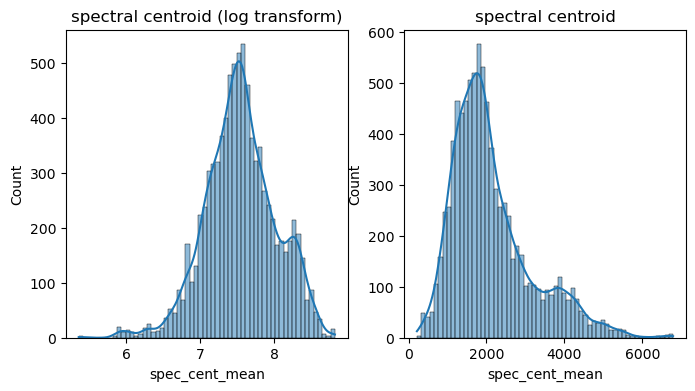

In [27]:
fig, axes = plt.subplots(ncols = 2, figsize = (8, 4))
sns.histplot(df['spec_cent_mean'].map(np.log), ax = axes[0], kde = True)
sns.histplot(df['spec_cent_mean'], ax = axes[1], kde = True)
axes[0].set_title('spectral centroid (log transform)')
axes[1].set_title('spectral centroid');

### Tempo 

In [28]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    onset_env = librosa.onset.onset_strength(y=samples, sr=sample_rate)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sample_rate)
    file_name = file.split('/')[-1]
    df.loc[df['slice_file_name'] == file_name, 'tempo'] = tempo


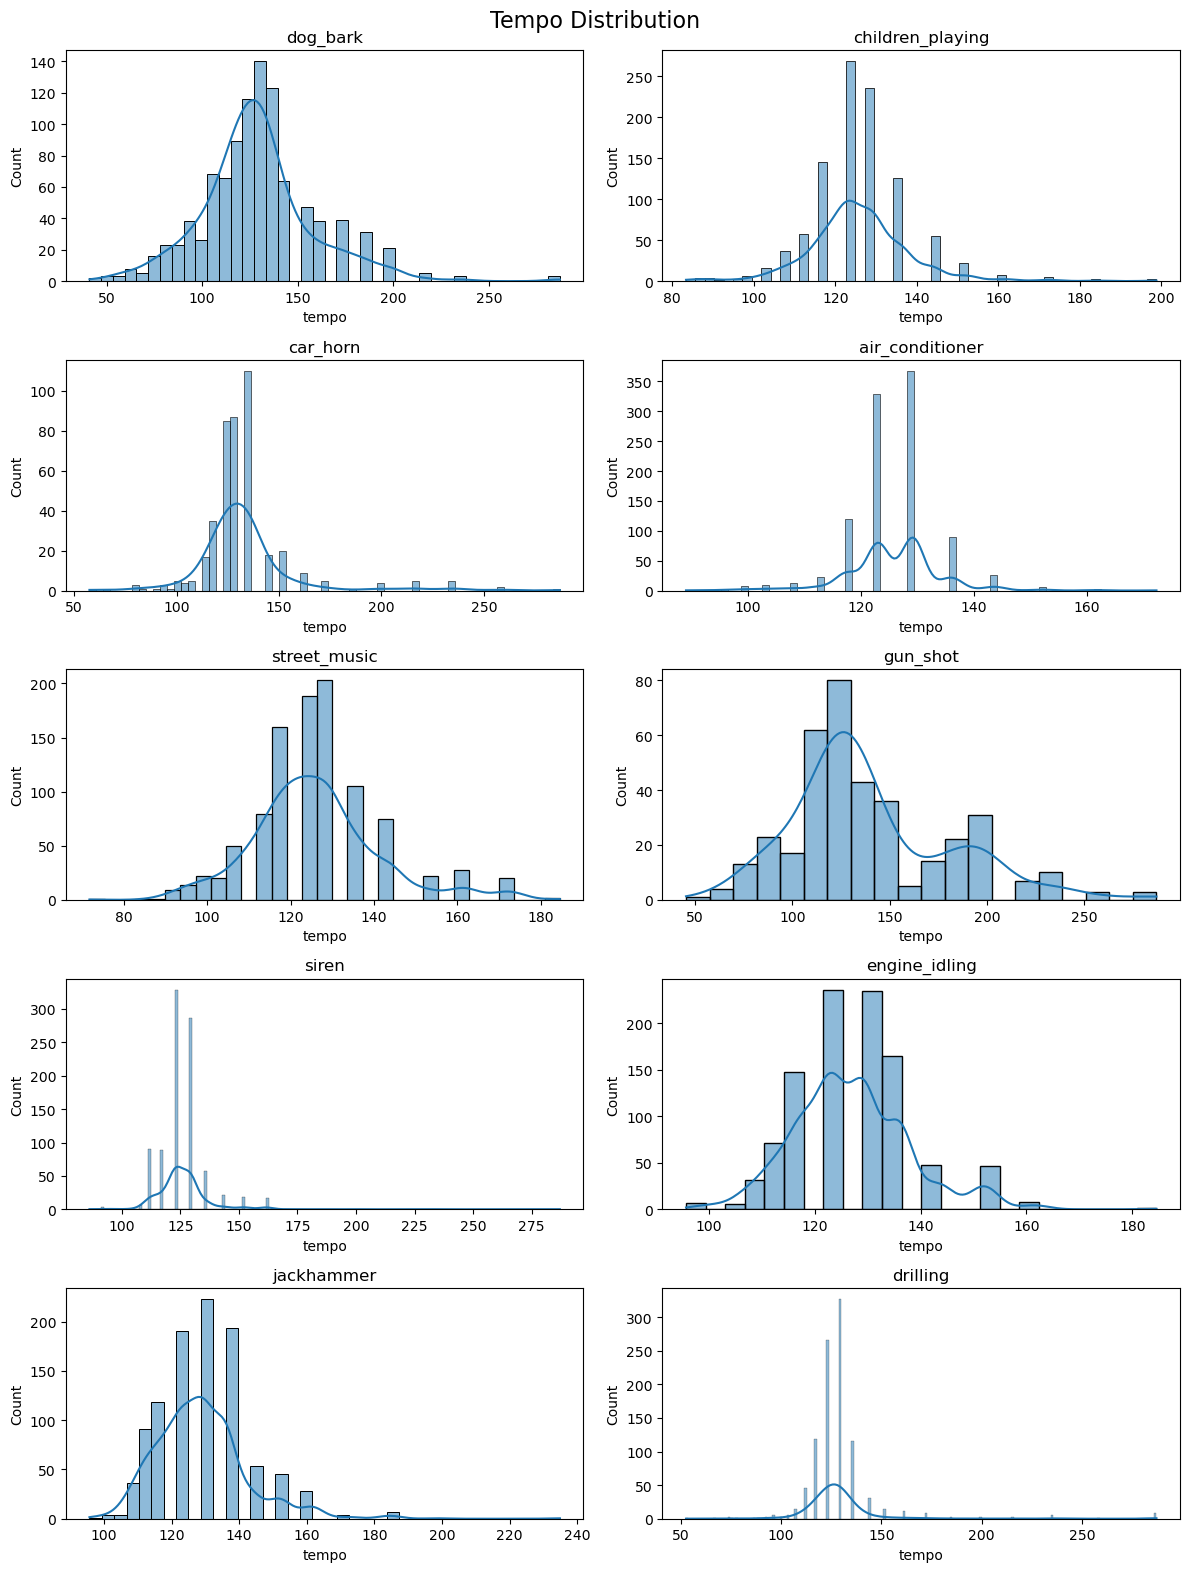

In [31]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 16))
for i, target in enumerate(df['class'].unique()):
    row = i // 2
    col = i % 2
    data = df.loc[df['class'] == target]
    sns.histplot(data, x = 'tempo', kde = True, ax = axes[row, col])
    axes[row, col].set_title(target)
fig.suptitle('Tempo Distribution', fontsize = 16)
plt.tight_layout()

class       tempo                        
                           mean        std          var
0   air_conditioner  125.708722   8.140195    66.262773
5     engine_idling  126.962860  11.053427   122.178239
8             siren  126.082584  11.998398   143.961560
2  children_playing  125.790642  12.374846   153.136818
7        jackhammer  128.825029  13.812930   190.797024
9      street_music  125.809573  15.342141   235.381288
4          drilling  128.951301  21.247700   451.464745
1          car_horn  132.893981  24.327627   591.833418
3          dog_bark  128.405927  29.710092   882.689539
6          gun_shot  139.700881  41.486537  1721.132711

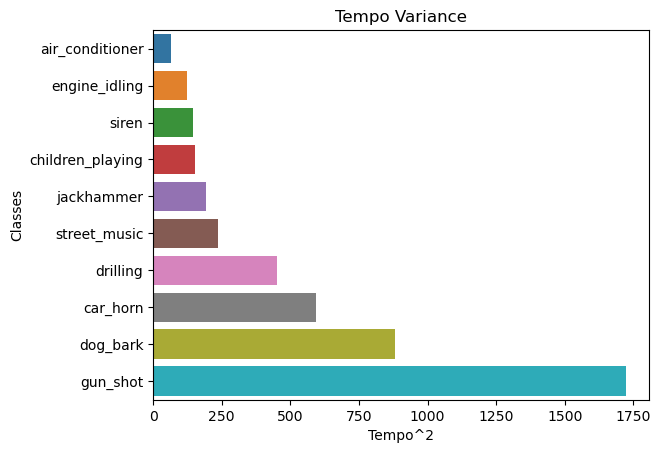

In [33]:
tempo = df.groupby('class').agg({'tempo': ['mean', 'std', 'var']}).reset_index().sort_values([('tempo', 'var')])

# sns.barplot(y = tempo['class'], x = tempo['tempo','mean'])
tempo_var = sns.barplot(y = tempo['class'], x = tempo[('tempo', 'var')]);
tempo_var.set(ylabel = 'Classes', xlabel = 'Tempo^2', title = 'Tempo Variance')
tempo

In [34]:
tempo.sort_values([('tempo', 'var')])

class       tempo                        
                           mean        std          var
0   air_conditioner  125.708722   8.140195    66.262773
5     engine_idling  126.962860  11.053427   122.178239
8             siren  126.082584  11.998398   143.961560
2  children_playing  125.790642  12.374846   153.136818
7        jackhammer  128.825029  13.812930   190.797024
9      street_music  125.809573  15.342141   235.381288
4          drilling  128.951301  21.247700   451.464745
1          car_horn  132.893981  24.327627   591.833418
3          dog_bark  128.405927  29.710092   882.689539
6          gun_shot  139.700881  41.486537  1721.132711

### Spectral Flux 

In [35]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    flux = librosa.onset.onset_strength(y=samples, sr=sample_rate)
    file_name = file.split('/')[-1]
    df.loc[df['slice_file_name'] == file_name, 's_flux_mean'] = flux.mean()
    df.loc[df['slice_file_name'] == file_name, 's_flux_std'] = flux.std()
    df.loc[df['slice_file_name'] == file_name, 's_flux_max'] = flux.max()


### Mel-Frequency Cepstral Coefficients (MFCCs) 

In [36]:
for file in audio_paths:
    samples, sample_rate = files_loaded[file]
    file_name = file.split('/')[-1]
    
    #extract mfccs and it's first and second derivative
    mfcc = librosa.feature.mfcc(y=samples, n_mfcc = 13, sr=sample_rate)
    mfcc_delta = librosa.feature.delta(mfcc, mode = 'wrap')
    mfcc_delta2 = librosa.feature.delta(mfcc, order = 2, mode = 'wrap')
    
    #aggregate mfccs features
    df.loc[df['slice_file_name'] == file_name, 'mfcc_mean'] = mfcc.mean()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_std'] = mfcc.std()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_max'] = mfcc.max()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_min'] = mfcc.min()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_25%'] = np.quantile(mfcc, 0.25)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_50%'] = np.quantile(mfcc, 0.5)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_75%'] = np.quantile(mfcc, 0.75)
    
    #aggregate mfccs deltas
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_mean'] = mfcc_delta.mean()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_std'] = mfcc_delta.std()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_max'] = mfcc_delta.max()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_min'] = mfcc_delta.min()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_25%'] = np.quantile(mfcc_delta, 0.25)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_50%'] = np.quantile(mfcc_delta, 0.5)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta_75%'] = np.quantile(mfcc_delta, 0.75)
    
    #aggregate mfcc delta2
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_mean'] = mfcc_delta2.mean()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_std'] = mfcc_delta2.std()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_max'] = mfcc_delta2.max()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_min'] = mfcc_delta2.min()
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_25%'] = np.quantile(mfcc_delta2, 0.25)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_50%'] = np.quantile(mfcc_delta2, 0.5)
    df.loc[df['slice_file_name'] == file_name, 'mfcc_delta2_75%'] = np.quantile(mfcc_delta2, 0.75)
    

In [42]:
corr_matrix = X.corr()
cond = abs(corr_matrix) >= 0.75
high_corr_df = corr_matrix.stack().reset_index().rename({0: 'correlation'}, axis = 1)
high_corr_df = high_corr_df.loc[(abs(high_corr_df['correlation']) >= 0.75) &
                               (abs(high_corr_df['correlation']) < 1)]
high_corr_df.loc[high_corr_df['level_0'] != high_corr_df['level_1']]
high_corr_df

,level_0,level_1,correlation
66,zcr_mean,spec_cent_mean,0.923494
98,zcr_std,spec_cent_std,0.755449
126,spec_cent_mean,zcr_mean,0.923494
136,spec_cent_mean,mfcc_max,-0.831154
158,spec_cent_std,zcr_std,0.755449
...,...,...,...
891,mfcc_delta2_25%,mfcc_delta_75%,-0.921107
898,mfcc_delta2_25%,mfcc_delta2_75%,-0.989850
951,mfcc_delta2_75%,mfcc_delta_25%,-0.929076
953,mfcc_delta2_75%,mfcc_delta_75%,0.931005


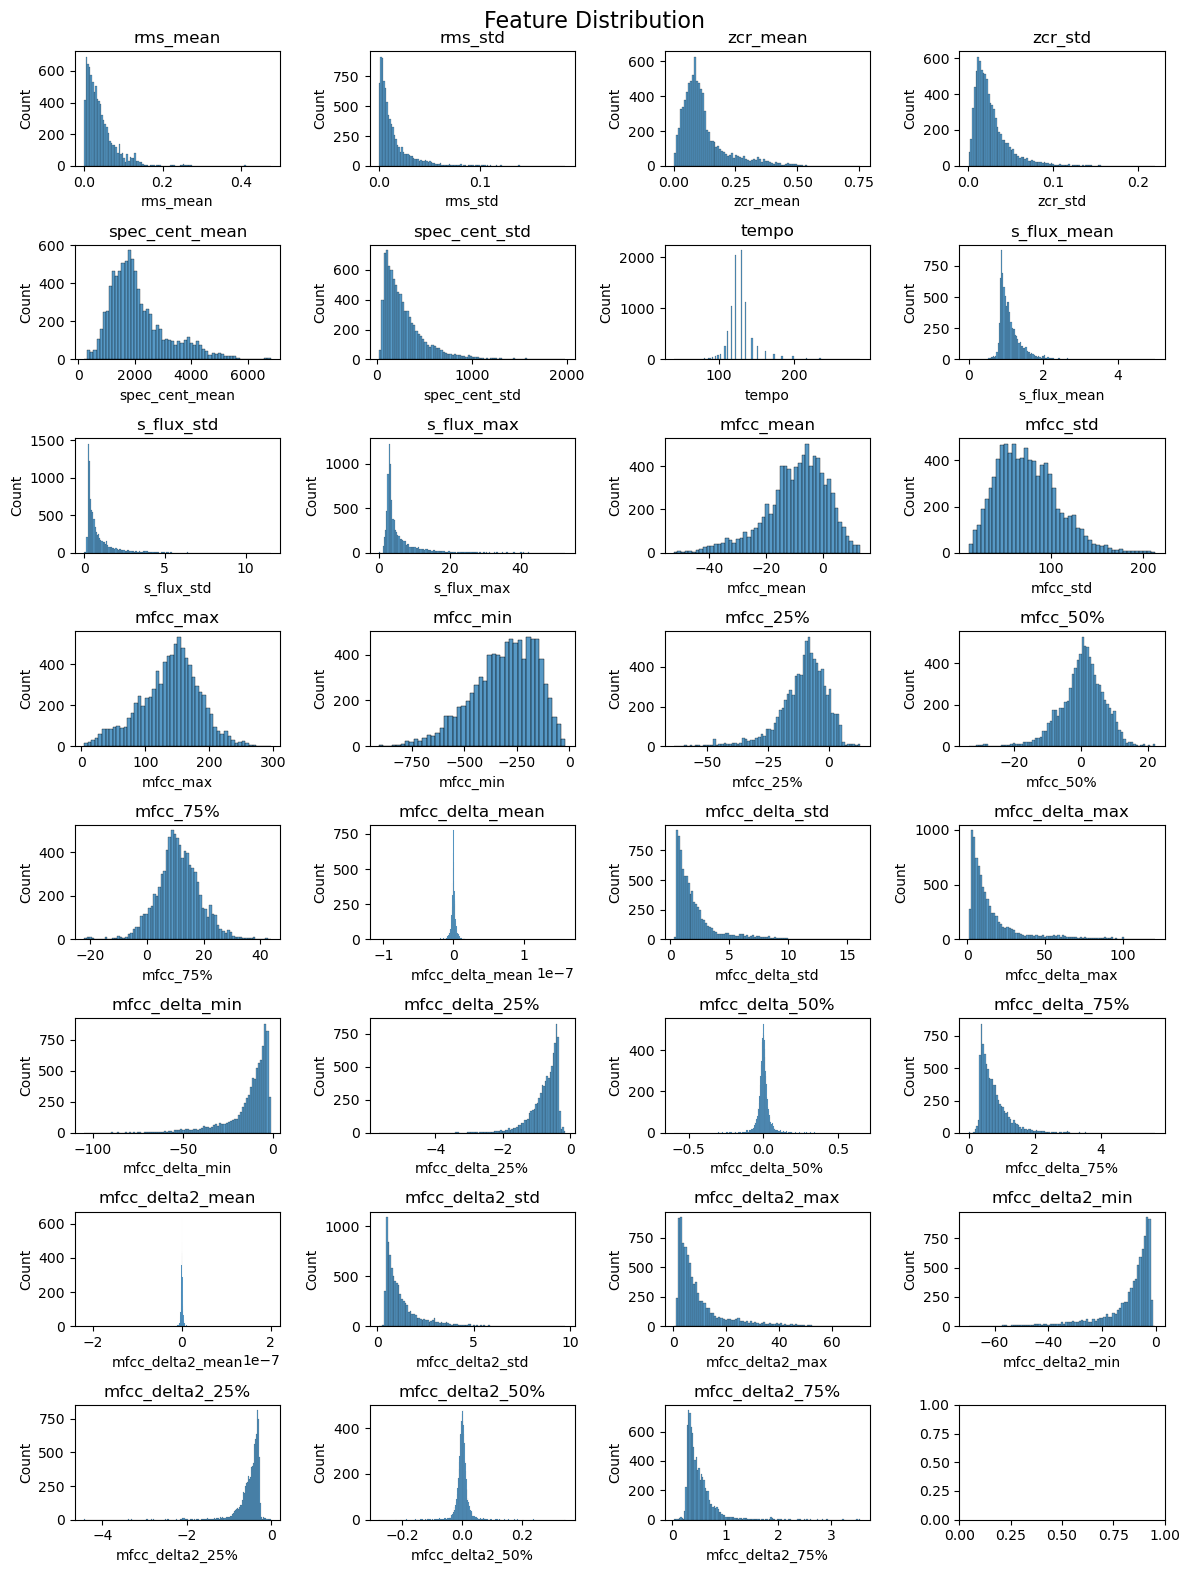

In [43]:
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (12, 16))

for i, feature in enumerate(X.columns):
    rows = i // 4
    cols = i % 4
    sns.histplot(X[feature], ax = axes[rows, cols]).set(title = feature)
plt.suptitle('Feature Distribution', fontsize = 16)
plt.tight_layout()
    